In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()  

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))    

In [ ]:
data_path = pathlib.Path("/content/drive/MyDrive/Brain_Tumor/")
data_path = os.path.join(data_path, os.listdir(data_path)[2])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


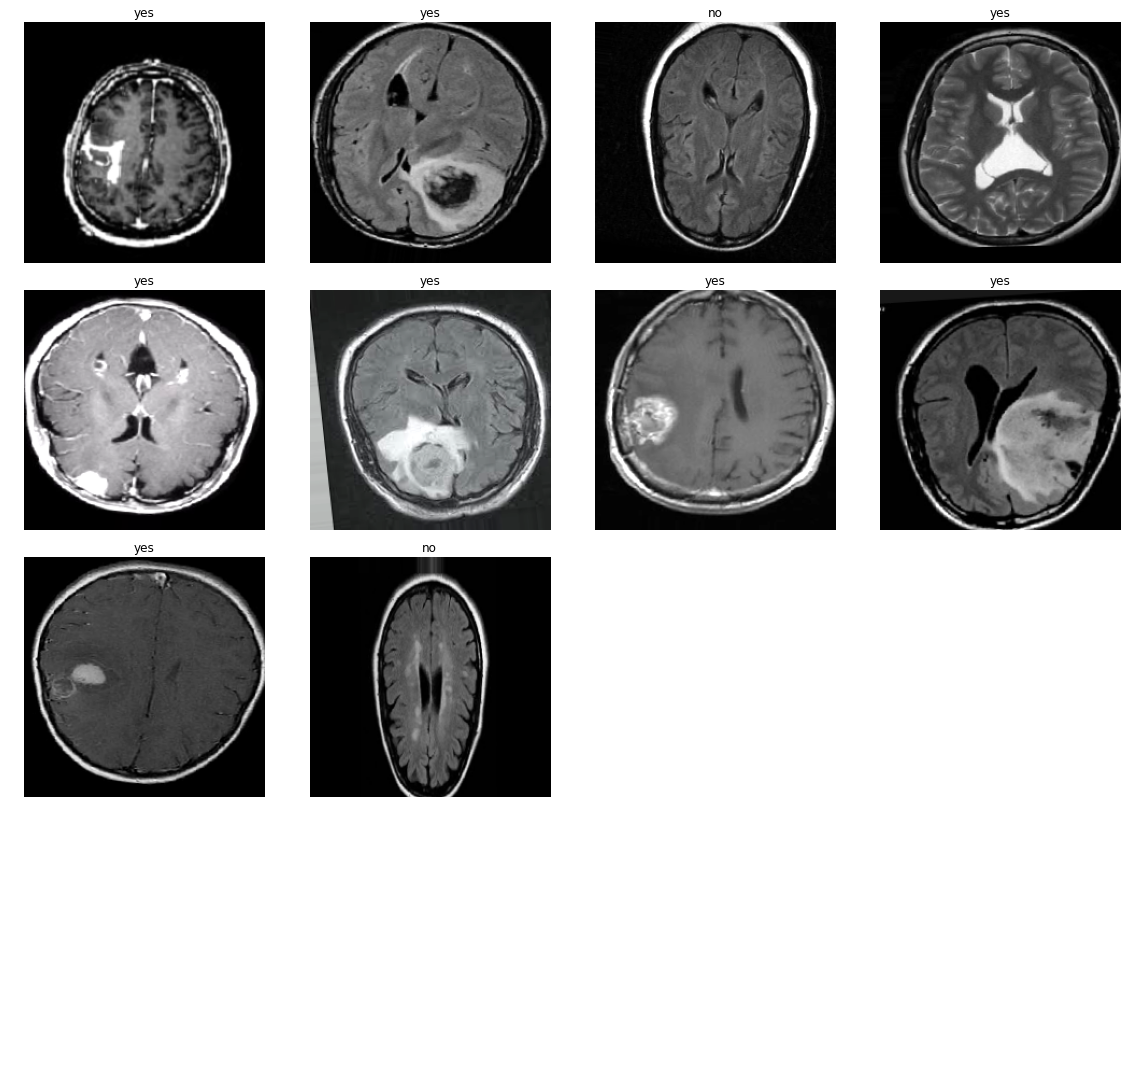

In [ ]:
sample_X , sample_y = train_generator.next()
mapping = {1:"yes" , 0:"no"}

plot_categories(sample_X,sample_y,mapping,sample_X.shape[0])

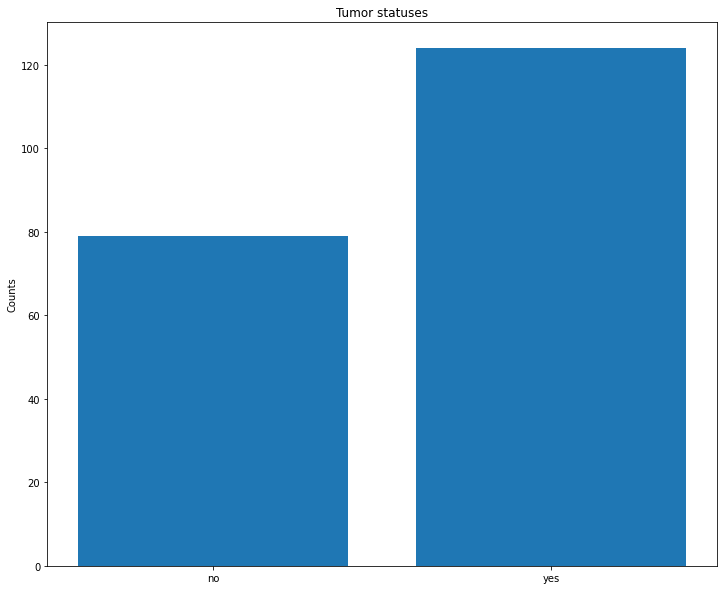

In [ ]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

In [ ]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

### Simple CNN Model

In [ ]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) # image of models structure you can get from output folder
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0

In [ ]:
history1 = model.fit(train_generator,epochs = 100, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
21/21 [==============================] - 39s 1s/step - loss: 0.6754 - tp: 66.0000 - fp: 33.0000 - tn: 46.0000 - fn: 58.0000 - accuracy: 0.5517 - precision: 0.6667 - recall: 0.5323 - auc: 0.6059 - prc: 0.6824 - val_loss: 0.6420 - val_tp: 18.0000 - val_fp: 4.0000 - val_tn: 15.0000 - val_fn: 13.0000 - val_accuracy: 0.6600 - val_precision: 0.8182 - val_recall: 0.5806 - val_auc: 0.7793 - val_prc: 0.8668
Epoch 2/100
21/21 [==============================] - 6s 264ms/step - loss: 0.5889 - tp: 97.0000 - fp: 25.0000 - tn: 54.0000 - fn: 27.0000 - accuracy: 0.7438 - precision: 0.7951 - recall: 0.7823 - auc: 0.7684 - prc: 0.7865 - val_loss: 0.6271 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 15.0000 - val_fn: 14.0000 - val_accuracy: 0.6400 - val_precision: 0.8095 - val_recall: 0.5484 - val_auc: 0.7963 - val_prc: 0.8569
Epoch 3/100
21/21 [==============================] - 6s 266ms/step - loss: 0.5709 - tp: 84.0000 - fp: 19.0000 - tn: 60.0000 - fn: 40.0000 - accuracy: 0.7094 - precision: 

In [ ]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.5890049934387207
tp :  24.0
fp :  4.0
tn :  15.0
fn :  7.0
accuracy :  0.7799999713897705
precision :  0.8571428656578064
recall :  0.774193525314331
auc :  0.8862479329109192
prc :  0.9307915568351746


Non-tumor detected (True Negatives):  16
Non-tumor incorrectly detected (False Positives):  3
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  24
Total case:  31


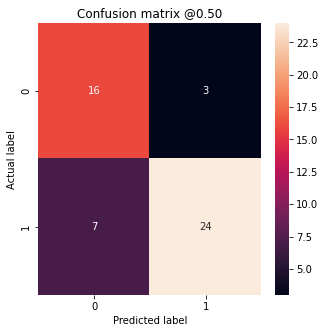

In [ ]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions)

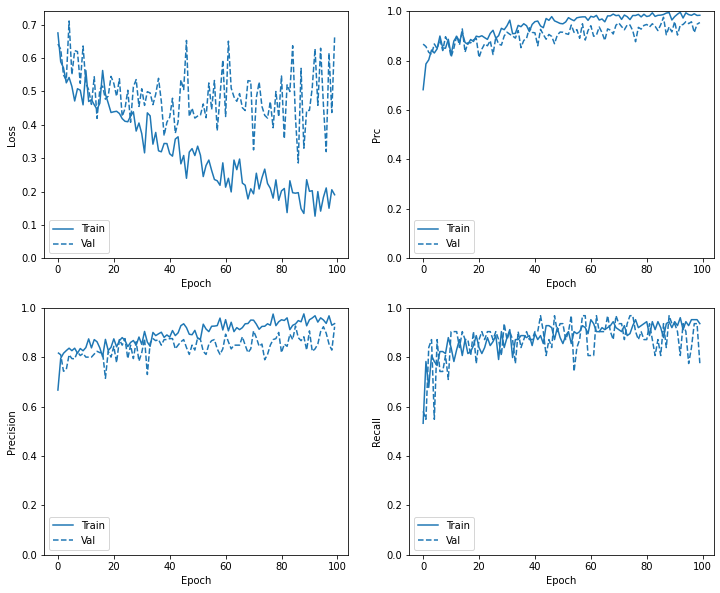

In [ ]:
plot_metrics(history1)

### InceptionResnetV2

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)



219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
history2 = model.fit(train_generator,epochs = 100, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
21/21 [==============================] - 28s 589ms/step - loss: 0.9054 - tp: 116.0000 - fp: 25.0000 - tn: 73.0000 - fn: 39.0000 - accuracy: 0.7470 - precision: 0.8227 - recall: 0.7484 - auc: 0.8216 - prc: 0.8569 - val_loss: 0.8943 - val_tp: 30.0000 - val_fp: 11.0000 - val_tn: 8.0000 - val_fn: 1.0000 - val_accuracy: 0.7600 - val_precision: 0.7317 - val_recall: 0.9677 - val_auc: 0.9058 - val_prc: 0.9139
Epoch 2/100
21/21 [==============================] - 7s 318ms/step - loss: 0.4445 - tp: 110.0000 - fp: 13.0000 - tn: 66.0000 - fn: 14.0000 - accuracy: 0.8670 - precision: 0.8943 - recall: 0.8871 - auc: 0.9115 - prc: 0.9328 - val_loss: 0.6368 - val_tp: 21.0000 - val_fp: 0.0000e+00 - val_tn: 19.0000 - val_fn: 10.0000 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6774 - val_auc: 0.9228 - val_prc: 0.9610
Epoch 3/100
21/21 [==============================] - 7s 311ms/step - loss: 0.4463 - tp: 100.0000 - fp: 13.0000 - tn: 66.0000 - fn: 24.0000 - accuracy: 0.8177 - pr

In [ ]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.4429399371147156
tp :  28.0
fp :  3.0
tn :  16.0
fn :  3.0
accuracy :  0.8799999952316284
precision :  0.9032257795333862
recall :  0.9032257795333862
auc :  0.9193548560142517
prc :  0.914732813835144


Non-tumor detected (True Negatives):  18
Non-tumor incorrectly detected (False Positives):  1
Tumor missed (False Negatives):  5
Tumor detected (True Positives):  26
Total case:  31


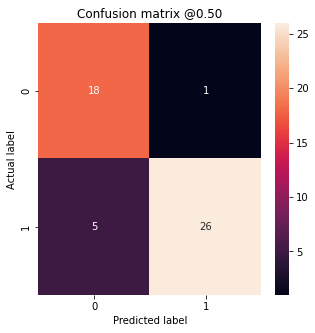

In [ ]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

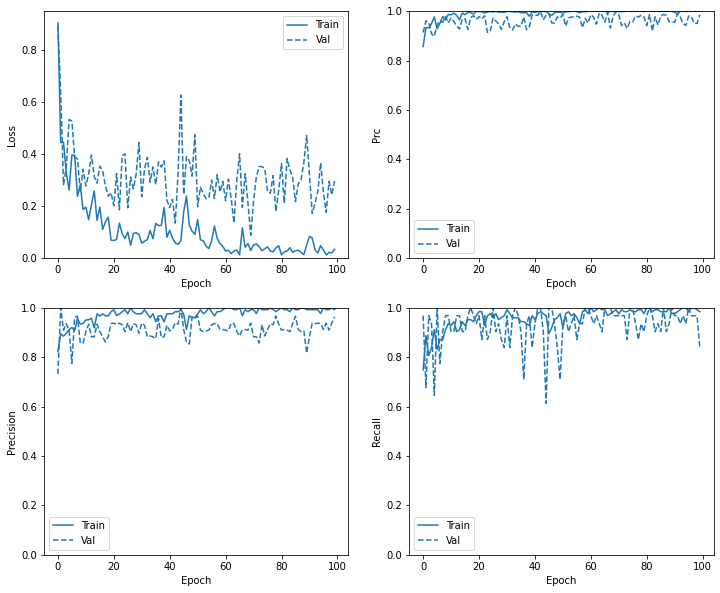

In [ ]:
plot_metrics(history2)

### VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
history3 = model.fit(train_generator,epochs = 100, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
21/21 [==============================] - 13s 372ms/step - loss: 0.7221 - tp: 96.0000 - fp: 39.0000 - tn: 59.0000 - fn: 59.0000 - accuracy: 0.6126 - precision: 0.7111 - recall: 0.6194 - auc: 0.6632 - prc: 0.7601 - val_loss: 0.5403 - val_tp: 31.0000 - val_fp: 13.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7400 - val_precision: 0.7045 - val_recall: 1.0000 - val_auc: 0.8523 - val_prc: 0.8757
Epoch 2/100
21/21 [==============================] - 6s 305ms/step - loss: 0.5952 - tp: 99.0000 - fp: 28.0000 - tn: 51.0000 - fn: 25.0000 - accuracy: 0.7389 - precision: 0.7795 - recall: 0.7984 - auc: 0.7564 - prc: 0.8047 - val_loss: 0.4935 - val_tp: 29.0000 - val_fp: 8.0000 - val_tn: 11.0000 - val_fn: 2.0000 - val_accuracy: 0.8000 - val_precision: 0.7838 - val_recall: 0.9355 - val_auc: 0.8574 - val_prc: 0.8867
Epoch 3/100
21/21 [==============================] - 6s 300ms/step - loss: 0.5333 - tp: 87.0000 - fp: 22.0000 - tn: 57.0000 - fn: 37.0000 - accuracy: 0.7094 - precis

In [ ]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.5547566413879395
tp :  24.0
fp :  4.0
tn :  15.0
fn :  7.0
accuracy :  0.7799999713897705
precision :  0.8571428656578064
recall :  0.774193525314331
auc :  0.8862478137016296
prc :  0.9230575561523438


Non-tumor detected (True Negatives):  17
Non-tumor incorrectly detected (False Positives):  2
Tumor missed (False Negatives):  7
Tumor detected (True Positives):  24
Total case:  31


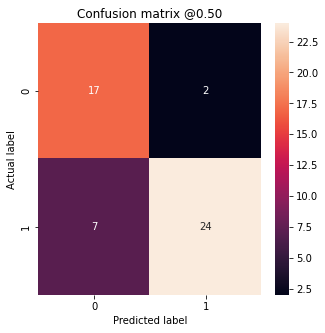

In [ ]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

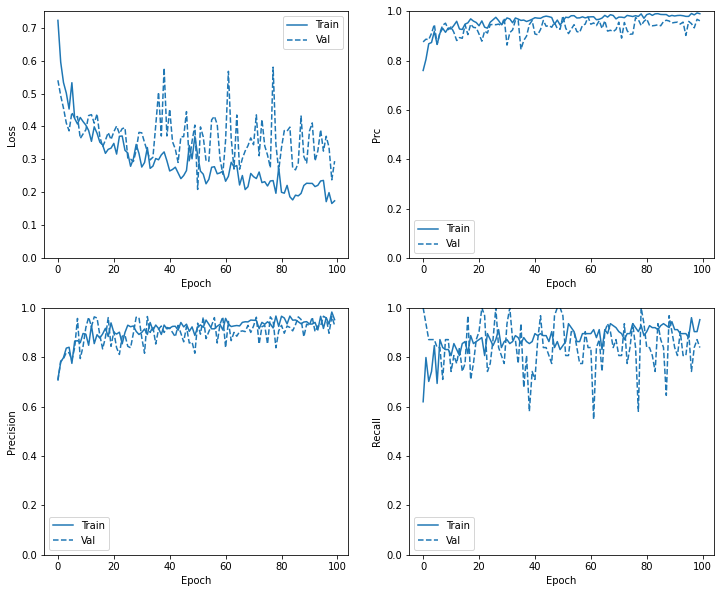

In [ ]:
plot_metrics(history3)

### MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(1024, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00008),
                loss = "binary_crossentropy",
                metrics=metrics)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
history4 = model.fit(train_generator,epochs = 100, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
21/21 [==============================] - 12s 341ms/step - loss: 0.6642 - tp: 113.0000 - fp: 38.0000 - tn: 60.0000 - fn: 42.0000 - accuracy: 0.6838 - precision: 0.7483 - recall: 0.7290 - auc: 0.7161 - prc: 0.7855 - val_loss: 0.4866 - val_tp: 23.0000 - val_fp: 2.0000 - val_tn: 17.0000 - val_fn: 8.0000 - val_accuracy: 0.8000 - val_precision: 0.9200 - val_recall: 0.7419 - val_auc: 0.9092 - val_prc: 0.9408
Epoch 2/100
21/21 [==============================] - 5s 249ms/step - loss: 0.4904 - tp: 92.0000 - fp: 15.0000 - tn: 64.0000 - fn: 32.0000 - accuracy: 0.7685 - precision: 0.8598 - recall: 0.7419 - auc: 0.8551 - prc: 0.9092 - val_loss: 0.3264 - val_tp: 27.0000 - val_fp: 3.0000 - val_tn: 16.0000 - val_fn: 4.0000 - val_accuracy: 0.8600 - val_precision: 0.9000 - val_recall: 0.8710 - val_auc: 0.9542 - val_prc: 0.9757
Epoch 3/100
21/21 [==============================] - 5s 248ms/step - loss: 0.3833 - tp: 111.0000 - fp: 14.0000 - tn: 65.0000 - fn: 13.0000 - accuracy: 0.8670 - precisio

In [ ]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.27598270773887634
tp :  27.0
fp :  0.0
tn :  19.0
fn :  4.0
accuracy :  0.9200000166893005
precision :  1.0
recall :  0.8709677457809448
auc :  0.9770797491073608
prc :  0.9892808198928833


Non-tumor detected (True Negatives):  19
Non-tumor incorrectly detected (False Positives):  0
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  27
Total case:  31


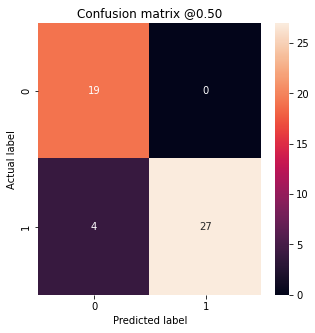

In [ ]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

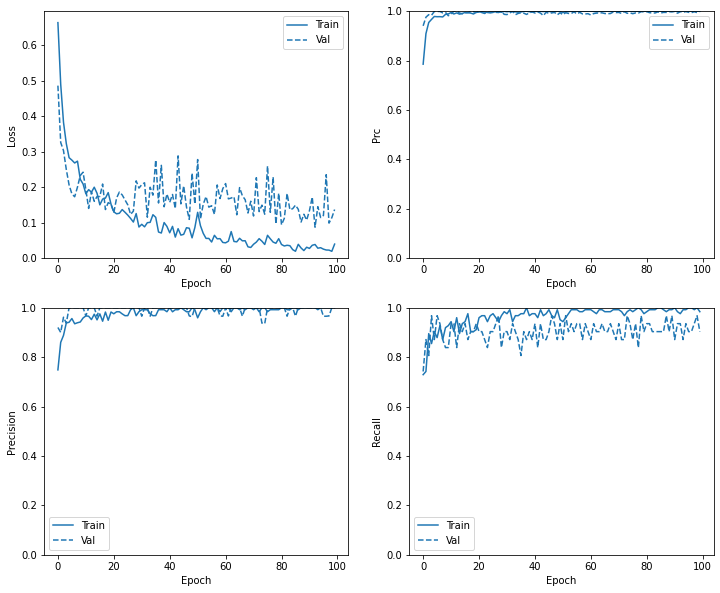

In [ ]:
plot_metrics(history4)

### Overall Result

In [ ]:
res = [["Simple CNN", ],
       ["InceptionResNetV2", ],
       ["VGG16", ],
       ["MobileNetV2"]]
histories = [history1,history2,history3,history4]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])

    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: # finding epoch with maximum AUC achieved
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN,0.878788,0.935484,0.954159,0.88,0.841914,0.870645,0.869177,0.8172
1,InceptionResNetV2,0.939394,1.000000,0.998302,0.96,0.912615,0.929355,0.955289,0.8988
2,VGG16,0.937500,0.967742,0.974533,0.94,0.898190,0.843226,0.923158,0.8396
3,MobileNetV2,1.000000,0.935484,1.000000,0.96,0.990793,0.903871,0.986358,0.9350
